# Web Scraping for Reddit & Predicting Comments

## Import stuff

In [441]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import time
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
import sklearn.metrics
from sklearn.grid_search import GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np 
from scipy import stats
import seaborn as sns

plt.style.use('fivethirtyeight')

%matplotlib inline

## Get the data

I choose to scrape the data in another Jupyter Notebook, so I don't accidentally re-run it and get different data.<BR />
I saved it as a csv. named reddit_data.csv<BR />
The data was scraped and saved to csv-file on Feb 18th 2018 at 6:15 pm

## Load the data

In [442]:
reddit_df = pd.read_csv('./reddit_data.csv')

reddit_df.head(3) 

,Unnamed: 0,doc
0,0,"<!doctype html><html xmlns=""http://www.w3.org/..."
1,1,"<!doctype html><html xmlns=""http://www.w3.org/..."
2,2,"<!doctype html><html xmlns=""http://www.w3.org/..."


#### Make data frame into a list to make it easier to work with

In [443]:
rlist = reddit_df['doc'].tolist() 

## Get required info
1. The title of the thread
2. The subreddit that the thread corresponds to
3. The length of time it has been up on Reddit
4. The number of comments on the thread

### Function to get data out of pages (titles, subreddits, time since posted, comments)

In [444]:
def get_data_from_page(page):
    soup = BeautifulSoup(page, 'lxml')
    data_needed = []
    elements = soup.find_all('div', {'class':'entry'})
    for element in elements: 
        title = element.find('a', {'class':'title'}).text
        subreddit = element.find('a', {'class':'subreddit'}).text
        time_up = element.find('time', {'class':'live-timestamp'}).text
        comment = element.find('a', {'class':'bylink'}).text
        data_needed.append([title, subreddit, time_up, comment])     
    return data_needed

#### Run function to get the data from the pages

In [445]:
reddit_data = pd.DataFrame(columns=['title', 'subreddit', 'time_up', 'comments'])
for page in rlist:
    data = get_data_from_page(page)
    for line in data:
        reddit_data = reddit_data.append(pd.Series(line, index=reddit_data.columns),ignore_index=True)

reddit_data.head(3)

,title,subreddit,time_up,comments
0,Top U.S. officials tell the world to ignore Tr...,r/worldnews,4 hours ago,834 comments
1,a cult classic,r/evilbuildings,3 hours ago,315 comments
2,Randy Bryce slams Paul Ryan for snubbing Flori...,r/BlueMidterm2018,6 hours ago,390 comments


#### Look and tail to see that all data is in

In [446]:
reddit_data.tail() 

,title,subreddit,time_up,comments
534,"🎶 Okay ladies, now let's get into gaping 🎶",r/BlackPeopleTwitter,4 hours ago,6 comments
535,The Joker put in that work (work work work wor...,r/BlackPeopleTwitter,5 hours ago,17 comments
536,How not to Diplomatic Flag of Nepal,r/vexillology,10 hours ago,64 comments
537,Buzz Lightbeer,r/funny,8 hours ago,31 comments
538,“2018 is a gays only event”,r/CringeAnarchy,10 hours ago,94 comments


## Munge the Data

In [447]:
reddit_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539 entries, 0 to 538
Data columns (total 4 columns):
title        539 non-null object
subreddit    539 non-null object
time_up      539 non-null object
comments     539 non-null object
dtypes: object(4)
memory usage: 16.9+ KB


### Work the time_up column

#### Remove the text string ' hours ago'

In [448]:
reddit_data['time_up'] = reddit_data['time_up'].str.replace(' hours ago', '')
reddit_data['time_up'] = reddit_data['time_up'].str.replace(' hour ago', '')

#### Make the rest of the string to numeric

In [449]:
reddit_data['time_up'] = pd.to_numeric(reddit_data['time_up'])

#### Look at the data type

In [450]:
reddit_data.dtypes

title        object
subreddit    object
time_up       int64
comments     object
dtype: object

#### Look at the unique values

In [451]:
reddit_data['time_up'].unique()

array([ 4,  3,  6,  5,  7,  9,  8, 10, 12,  2, 11, 13, 14, 15, 16, 17,  1,
       18])

### Work the comments column

#### Remove the text string ' comments'

In [452]:
reddit_data['comments'] = reddit_data['comments'].str.replace(' comments', '')

#### Make the rest of the string to numeric

In [453]:
reddit_data['comments'] = pd.to_numeric(reddit_data['comments'])

#### Look at the data type

In [454]:
reddit_data.dtypes

title        object
subreddit    object
time_up       int64
comments      int64
dtype: object

#### Look at the unique values

In [455]:
reddit_data['comments'].unique()

array([ 834,  315,  390,  351,  979,  327,  116,  774,  395,  226,  128,
        654,  520,  744,  338,  184,  985,  109,  278,  617,   88,  411,
        326,  129, 2131,  145,   96,   72,  270, 1553,  797,  252, 1110,
        234,  285,  511,  210, 1786,  255,  139,  279,   54,  124,  115,
       1201, 1993,   73,  573,  331,  597,   61,   71, 2350,  463,  667,
         94,  169,   89,  848,  670,  151,  217,  374,  732,  179, 2276,
        136, 5261,  651, 1391,  479,  211,   75,  394,   49,   82,  707,
        100,  319,   67,   35,   80,  144,   87,   77,   52,   95,  204,
        272, 1352,   62,  307,   41, 3164,  177,   66,   86,   31,   64,
        642,  897,  123,  191,   68,  119,  127,   32,  516,   43,   20,
        818,  182, 3896,   21,   37,  164,  254,   39,  170,   40,  288,
        330,   30,   26,  174,   99,  643, 1098,   50,   98,  113,   59,
        133,  462,  881,   84,  194,  245,  135,   74,   12,   10,   97,
        512,  108,   22,  101,  195,  111,   42,  1

### Look for missing values

In [456]:
reddit_data.isnull().sum()

title        0
subreddit    0
time_up      0
comments     0
dtype: int64

### Handle duplicates

#### Total numbers of posts

In [457]:
len(reddit_data)

539

#### Total numbers of posts without duplicates

In [458]:
len(reddit_data['title'].unique())

456

#### Drop duplicated rows based on title column

In [459]:
reddit_data = reddit_data.drop_duplicates(subset=['title'], keep='first')

#### Look and see that rows were dropped correctly

In [460]:
len(reddit_data)

456

### Look at statistical data for numerci columns

In [461]:
reddit_data.describe()

,time_up,comments
count,456.000000,456.000000
mean,7.585526,215.458333
std,3.188118,465.189143
min,1.000000,3.000000
25%,5.000000,31.000000
50%,7.000000,72.000000
75%,9.000000,177.500000
max,18.000000,5261.000000


### Create  dummies for subreddits

In [462]:
df_subreddit = pd.get_dummies(reddit_data['subreddit'])

df_subreddit.head(3)

,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,r/AnimalTextGifs,r/AnimalsBeingDerps,r/ArcherFX,r/Art,...,r/wholesomebpt,r/wholesomegifs,r/woahdude,r/wokekids,r/worldnews,r/worldpolitics,r/xboxone,r/youdontsurf,r/youseeingthisshit,r/youtubehaiku
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Look at the 10 most occuring features (10 subreddits with highest count in or model)

In [463]:
top_subreddit = df_subreddit.sum().transpose().sort_values(0, ascending=False).transpose().head(10)

top_subreddit

r/pics                  16
r/aww                   15
r/funny                 11
r/FortNiteBR             8
r/BlackPeopleTwitter     8
r/todayilearned          8
r/rupaulsdragrace        5
r/marvelstudios          5
r/food                   5
r/rarepuppers            4
dtype: int64

### Plot number of posts from different subreddits

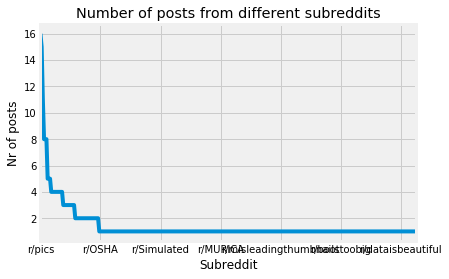

In [464]:
df_subreddit.sum().transpose().sort_values(0, ascending=False).transpose().plot.line()

plt.xlabel('Subreddit');
plt.ylabel('Nr of posts');
plt.title('Number of posts from different subreddits');

### Add subreddit dummies to data frame

In [465]:
reddit_data_subr = pd.concat([reddit_data, df_subreddit], axis=1)

reddit_data_subr.head(3)

,title,subreddit,time_up,comments,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,...,r/wholesomebpt,r/wholesomegifs,r/woahdude,r/wokekids,r/worldnews,r/worldpolitics,r/xboxone,r/youdontsurf,r/youseeingthisshit,r/youtubehaiku
0,Top U.S. officials tell the world to ignore Tr...,r/worldnews,4,834,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,a cult classic,r/evilbuildings,3,315,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Randy Bryce slams Paul Ryan for snubbing Flori...,r/BlueMidterm2018,6,390,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [466]:
len(reddit_data_subr)

456

## NLP

Natural language process on the title.

Use Count Vectorization and remove English stop words.

#### Instantiate model

In [467]:
cvec = CountVectorizer(stop_words='english') # remove English stopwords

#### Fit to the data

In [468]:
cvec.fit(reddit_data_subr['title'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

#### Transform to generate features

In [469]:
cvecdata = cvec.transform(reddit_data_subr['title'])

#### Turn features into a data frame

In [470]:
df_title  = pd.DataFrame(cvecdata.todense(),
             columns=cvec.get_feature_names())

df_title.head(3)

,000,004,03,10,100,1000k,1020,1024x683,110mm,1175,...,yes,yesterday,yiga,york,young,youtube,ysk,zigfred,zoomies,þrídrangar
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Look at the 10 most occuring features (10 words with highest count in or model)

In [471]:
top_title = df_title.sum().transpose().sort_values(0, ascending=False).transpose().head(10)

top_title

year      13
people    12
just      12
work      11
time      11
til       10
oc         9
don        9
black      8
trump      7
dtype: int64

### Plot number of posts with different words

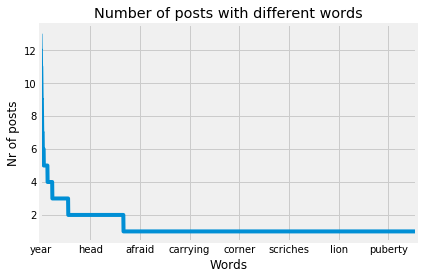

In [472]:
df_title.sum().transpose().sort_values(0, ascending=False).transpose().plot.line()

plt.xlabel('Words');
plt.ylabel('Nr of posts');
plt.title('Number of posts with different words');

In [473]:
len(df_title)

456

### Add words from title to data frame

In [474]:
reddit = pd.concat([reddit_data_subr, df_title], axis=1)

reddit.head(3)

,title,subreddit,time_up,comments,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,...,yes,yesterday,yiga,york,young,youtube,ysk,zigfred,zoomies,þrídrangar
0,Top U.S. officials tell the world to ignore Tr...,r/worldnews,4.0,834.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a cult classic,r/evilbuildings,3.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Randy Bryce slams Paul Ryan for snubbing Flori...,r/BlueMidterm2018,6.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [475]:
len(reddit)

532

### Delta from median of comments

Comments higher or lower than median will be our binary variable that we can use when we predict with our classification model.

#### Median for comments

In [476]:
med_com = reddit['comments'].median()

med_com

72.0

#### Create new column indicating delta from median of comments and insert it into the data frame

In [477]:
reddit['delta_com'] = reddit['comments'].apply(lambda x: x - med_com)

reddit.head(3)

,title,subreddit,time_up,comments,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,...,yesterday,yiga,york,young,youtube,ysk,zigfred,zoomies,þrídrangar,delta_com
0,Top U.S. officials tell the world to ignore Tr...,r/worldnews,4.0,834.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,762.0
1,a cult classic,r/evilbuildings,3.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0
2,Randy Bryce slams Paul Ryan for snubbing Flori...,r/BlueMidterm2018,6.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0


### Create class based on comments above or below median

over median = class 1<BR />
under or equal to median = class 0

In [478]:
reddit['class_com'] = reddit['comments'].apply(lambda x: 1 if x > med_com else 0)

reddit.head(3)

,title,subreddit,time_up,comments,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,...,yiga,york,young,youtube,ysk,zigfred,zoomies,þrídrangar,delta_com,class_com
0,Top U.S. officials tell the world to ignore Tr...,r/worldnews,4.0,834.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,762.0,1
1,a cult classic,r/evilbuildings,3.0,315.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,243.0,1
2,Randy Bryce slams Paul Ryan for snubbing Flori...,r/BlueMidterm2018,6.0,390.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,318.0,1


#### Look at missing values

In [479]:
reddit.isnull().sum()

title                      76
subreddit                  76
time_up                    76
comments                   76
r/2meirl4meirl             76
r/ATBGE                    76
r/AbandonedPorn            76
r/AccidentalRenaissance    76
r/AccidentalWesAnderson    76
r/Android                  76
r/AnimalTextGifs           76
r/AnimalsBeingDerps        76
r/ArcherFX                 76
r/Art                      76
r/ArtefactPorn             76
r/AskHistorians            76
r/AskNYC                   76
r/AskReddit                76
r/Astronomy                76
r/BeAmazed                 76
r/BestOfReports            76
r/BetterEveryLoop          76
r/BigCatGifs               76
r/BikiniBottomTwitter      76
r/Bitcoin                  76
r/BlackPeopleTwitter       76
r/Blep                     76
r/BlueMidterm2018          76
r/BoJackHorseman           76
r/BokuNoHeroAcademia       76
                           ..
works                      76
world                      76
worry     

#### Drop missing values

In [480]:
reddit = reddit.dropna(axis=0, how='any')

#### Look and see that rows were dropped

In [481]:
len(reddit)

380

## Train Test Split

Divide the data into a train and a test set (with a test set of 30%)<BR />
If there is time go back to this step and change random seed/state.<BR />
Ultimatly do this 3 times.

In [482]:
dep   = reddit['class_com']
indep = reddit

In [483]:
indep_train, indep_test, dep_train, dep_test = train_test_split(indep, dep, test_size = 0.3, random_state=24)

## EDA

#### Look ast the shape of the data

In [484]:
print(reddit.shape)
print(indep_train.shape)
print(dep_train.shape)
print(indep_test.shape)
print(dep_test.shape)

(380, 2212)
(266, 2212)
(266,)
(114, 2212)
(114,)


### Histograms to show distribution

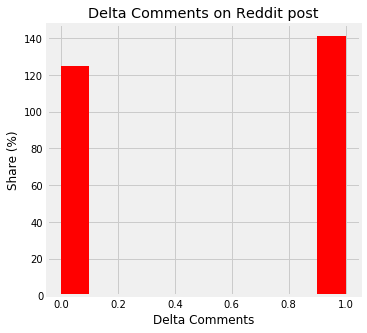

In [485]:
# delta comments
dep_train.plot(kind='hist', figsize=(5,5), color='red'); 
plt.xlabel('Delta Comments');
plt.ylabel('Share (%)');
plt.title('Delta Comments on Reddit post');

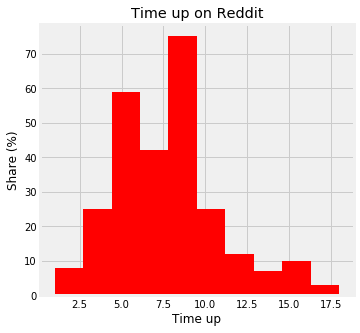

In [486]:
# time up
indep_train['time_up'].plot(kind='hist', figsize=(5,5), color='red'); 
plt.xlabel('Time up');
plt.ylabel('Share (%)');
plt.title('Time up on Reddit');

In [487]:
# Correlation
np.corrcoef(dep_train, indep_train['time_up'])

array([[1.        , 0.31958332],
       [0.31958332, 1.        ]])

In [488]:
np.corrcoef(dep_train, indep_train['r/aww'])

array([[ 1.     , -0.05151],
       [-0.05151,  1.     ]])

In [489]:
np.corrcoef(dep_train, indep_train['r/pics'])

array([[1.        , 0.04423127],
       [0.04423127, 1.        ]])

In [490]:
np.corrcoef(dep_train, indep_train['time'])

array([[1.        , 0.01939158],
       [0.01939158, 1.        ]])

In [491]:
np.corrcoef(dep_train, indep_train['year'])

array([[ 1.        , -0.04444429],
       [-0.04444429,  1.        ]])

In [492]:
np.corrcoef(dep_train, indep_train['comments'])

array([[1.        , 0.36134756],
       [0.36134756, 1.        ]])

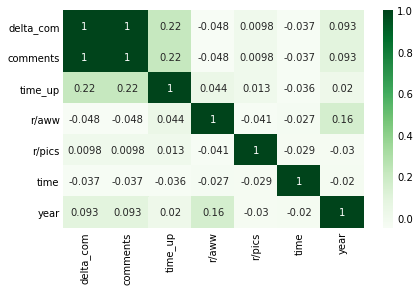

In [493]:
# heatmap
sns.heatmap(indep_train[['delta_com','comments','time_up','r/aww','r/pics','time','year' ]].corr(), 
            annot = True, cmap="Greens")

Low correlation among indep variables - GOOD<BR />
We need to drop comments since delta comments are made out of the comments column.<BR />
But also low correaltion between dep varable and indep variables - NOT so GOOD (we need good predictors)

**Use class based on above or below median (class_com) created above**

In [494]:
# somewhart unbalanced classes in the dependent variable
# One class is under median and the other one is over median
over = 0
under = 0
for d in indep_train['class_com']:
    if d == 1:
        over = over +1
    elif d == 0:
        under = under +1

print(over, under) # in numbers
print((over/(over+under)),(under/(over+under))) # in shares

141 125
0.5300751879699248 0.4699248120300752


The differences is balance is so small that we do not need to balance.<BR />
Around 30/70 you will need to balance.

## SCALE THE DATA + MODELS

LogisticRegression and Random Forest

Cross validation on each model and tune hyper parameters and features.<BR />
Fit on train set and score on test set (R2-score for example)

Use cross-validation to evaluate the model.<BR />
Evaluate the accuracy of the model, as well as any other metrics you feel are appropriate.

### Functions

In [495]:
def get_best_hype(model, grid, X_train, y_train):
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    
    # Best Hyperparameters
    gs = GridSearchCV(model, grid, scoring='roc_auc', cv=5)
    gs.fit(X_train_s, y_train)
    
    # fit
    model.fit(X_train_s, y_train) 
    return {'best_score': gs.best_score_,'best_params': gs.best_params_} 

def evaluate_model(model, X_train, X_test, y_train, y_test):
    # standardize the predictors
    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)
    
    # fit
    model.fit(X_train_s, y_train)
    
    # Evaluate: predict and score
    y_pred = model.predict(X_test_s)
    y_true = y_test
    
    accuracy = sklearn.metrics.accuracy_score(y_true, y_pred)
    
    # Evaluate: score and predict with cross_val
    score = cross_val_score(model, X_test_s, y_test, cv=5)
    pred = cross_val_predict(model, X_test_s, y_test)
    
    return {'accuracy': accuracy, 'y_pred_mean': y_pred.mean(), 'score_mean': score.mean(), 'pred_mean': pred.mean()} 

### LogisticRegression

**time_up**

Gridsearch, best C

In [510]:
# Declare indep and dep
indep_train1 = indep_train[['time_up']]
indep_test1 = indep_test[['time_up']]
dep_train1 = dep_train
dep_test1 = dep_test

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train1, dep_train1)

{'best_params': {'C': 1e-10, 'solver': 'newton-cg'},
 'best_score': 0.6949783325308344}

Model + best C

In [511]:
# chose model and use best C
model = LogisticRegression(C=1e-10)

# call function
evaluate_model(model, indep_train1, indep_test1, dep_train1, dep_test1)

{'accuracy': 0.6403508771929824,
 'pred_mean': 0.7982456140350878,
 'score_mean': 0.5965085638998683,
 'y_pred_mean': 0.5175438596491229}

**time_up + all words from NLP + all subreddit**

Gridsearch, best C

In [512]:
# Declare indep
# don't forget to drop a word and a subreddit
indep_train2 = indep_train.drop(['comments', 'delta_com', 'class_com','title', 'subreddit', 'got', 'r/gifs'], axis=1)
indep_test2 = indep_test.drop(['comments', 'delta_com', 'class_com','title', 'subreddit', 'got', 'r/gifs'], axis=1)

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train2, dep_train)

{'best_params': {'C': 1e-10, 'solver': 'newton-cg'},
 'best_score': 0.5283599392570095}

Model + best C

In [513]:
# chose model and use best C
model = LogisticRegression(C=1e-10)

# call function
evaluate_model(model, indep_train2, indep_test2, dep_train, dep_test)

{'accuracy': 0.5526315789473685,
 'pred_mean': 0.8157894736842105,
 'score_mean': 0.5688405797101449,
 'y_pred_mean': 0.5}

###########

Baseline

In [514]:
baseline = np.mean(indep_train[indep_train['class_com'] == 0].shape[0]/indep_train.shape[0]) 
baseline

0.4699248120300752

######################################################################

**time_up + all words from NLP**

In [515]:
# Columns with dummies from subreddit (I do not want to use them in this case)
indep_train.iloc[:, 4:318].head(3)

,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,r/AnimalTextGifs,r/AnimalsBeingDerps,r/ArcherFX,r/Art,...,r/wholesomebpt,r/wholesomegifs,r/woahdude,r/wokekids,r/worldnews,r/worldpolitics,r/xboxone,r/youdontsurf,r/youseeingthisshit,r/youtubehaiku
448,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Make new data frame and drop the dummies from subreddits

In [516]:
indep_trainW = indep_train.drop(indep_train.iloc[:, 4:318], axis=1)

indep_trainW.head(3)

,title,subreddit,time_up,comments,000,004,03,10,100,1000k,...,yiga,york,young,youtube,ysk,zigfred,zoomies,þrídrangar,delta_com,class_com
448,"""I-I'm not flat! Baka!""",r/DDLC,9.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,26.0,1
451,"Halley's Comet... May 15, 1910",r/Astronomy,11.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-37.0,0
275,Categorised most locations in Fortnite for the...,r/FortNiteBR,8.0,231.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,159.0,1


In [517]:
indep_testW = indep_test.drop(indep_test.iloc[:, 4:318], axis=1)

indep_testW.head(3)

,title,subreddit,time_up,comments,000,004,03,10,100,1000k,...,yiga,york,young,youtube,ysk,zigfred,zoomies,þrídrangar,delta_com,class_com
228,Disappointed father walks in on son dressed up...,r/LivestreamFail,5.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,193.0,1
138,[Poetry] LIL HAM - XANNY POPPIN,r/youtubehaiku,8.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92.0,1
52,Legal snafu,r/coaxedintoasnafu,9.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43.0,1


Gridsearch, best C

In [518]:
# Declare indep
# don't forget to drop a word
indep_train4 = indep_trainW.drop(['comments', 'delta_com', 'class_com', 'title', 'subreddit','got'], axis=1)
indep_test4 = indep_testW.drop(['comments', 'delta_com', 'class_com', 'title', 'subreddit','got'], axis=1)

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train4, dep_train)

{'best_params': {'C': 100.0, 'solver': 'newton-cg'},
 'best_score': 0.5312780102966776}

Model + best C

In [519]:
# chose model and use best C
model = LogisticRegression(C=100.0)

# call function
evaluate_model(model, indep_train4, indep_test4, dep_train, dep_test)

{'accuracy': 0.4473684210526316,
 'pred_mean': 0.5350877192982456,
 'score_mean': 0.5969038208168642,
 'y_pred_mean': 0.11403508771929824}

######

**What are the 10 most important features and what words does the features correspond to?**

In [520]:
# Look at the feature importance with coef_
pd.Series(dict(zip(indep_train4.columns,model.coef_[0]))).abs().sort_values(ascending=False).head(11)

fucking                0.988084
interesting            0.866266
happiness              0.826502
downhill               0.786014
absolutelynotme_irl    0.772542
rollin                 0.772542
watching               0.752456
flip                   0.745633
legit                  0.745633
time_up                0.740577
eye                    0.654414
dtype: float64

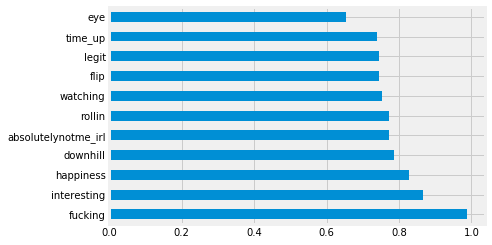

In [521]:
pd.Series(dict(zip(indep_train4.columns,model.coef_[0]))).abs().sort_values(ascending=False).head(11).plot(kind='barh');

#########

**time_up + 10 most important words from feature importance test**

Gridsearch, best C

In [522]:
# Declare indep
indep_train18 = indep_train[['time_up', 'legit', 'flip', 'watching', 'rollin', 'absolutelynotme_irl', 'downhill' ,'happiness', 'interesting', 'fucking', 'eye']]
indep_test18 = indep_test[['time_up', 'legit', 'flip', 'watching', 'rollin', 'absolutelynotme_irl', 'downhill' ,'happiness', 'interesting', 'fucking', 'eye']]

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train18, dep_train)

{'best_params': {'C': 1e-10, 'solver': 'newton-cg'},
 'best_score': 0.7135620763731989}

Model + best C

In [523]:
# chose model and use best C
model = LogisticRegression(C=1e-10)

# call function
evaluate_model(model, indep_train18, indep_test18, dep_train, dep_test)

{'accuracy': 0.6403508771929824,
 'pred_mean': 0.8508771929824561,
 'score_mean': 0.5965085638998683,
 'y_pred_mean': 0.5175438596491229}

######

**time_up + top 10 words from NLP**

In [524]:
# Declare indep
indep_train8 = indep_train[['time_up','year', 'people','just','work','time','til', 'oc', 'don', 'black', 'trump']]
indep_test8 = indep_test[['time_up','year', 'people','just','work','time','til', 'oc', 'don', 'black', 'trump']]

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train8, dep_train)

{'best_params': {'C': 1e-09, 'solver': 'newton-cg'},
 'best_score': 0.666619689618134}

Model + best C

In [525]:
# chose model and use best C
model = LogisticRegression(C=1e-9)

# call function
evaluate_model(model, indep_train8, indep_test8, dep_train, dep_test)

{'accuracy': 0.6228070175438597,
 'pred_mean': 0.6578947368421053,
 'score_mean': 0.5798418972332016,
 'y_pred_mean': 0.5175438596491229}

#########################################

**time_up + all subreddit dummies**

#### Make new data frame and exclude the words from NLP

In [526]:
indep_trainS = indep_train.iloc[:, 0:318]

indep_trainS.head(3)

,title,subreddit,time_up,comments,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,...,r/wholesomebpt,r/wholesomegifs,r/woahdude,r/wokekids,r/worldnews,r/worldpolitics,r/xboxone,r/youdontsurf,r/youseeingthisshit,r/youtubehaiku
448,"""I-I'm not flat! Baka!""",r/DDLC,9.0,98.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
451,"Halley's Comet... May 15, 1910",r/Astronomy,11.0,35.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
275,Categorised most locations in Fortnite for the...,r/FortNiteBR,8.0,231.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [527]:
indep_testS = indep_test.iloc[:, 0:318]

indep_testS.head(3)

,title,subreddit,time_up,comments,r/2meirl4meirl,r/ATBGE,r/AbandonedPorn,r/AccidentalRenaissance,r/AccidentalWesAnderson,r/Android,...,r/wholesomebpt,r/wholesomegifs,r/woahdude,r/wokekids,r/worldnews,r/worldpolitics,r/xboxone,r/youdontsurf,r/youseeingthisshit,r/youtubehaiku
228,Disappointed father walks in on son dressed up...,r/LivestreamFail,5.0,265.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
138,[Poetry] LIL HAM - XANNY POPPIN,r/youtubehaiku,8.0,164.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
52,Legal snafu,r/coaxedintoasnafu,9.0,115.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Gridsearch, best C

In [529]:
# Declare indep
# don't forget to drop a subreddit
indep_train6 = indep_trainS.drop(['comments', 'title', 'subreddit','r/gifs'], axis=1)
indep_test6 = indep_testS.drop(['comments', 'title', 'subreddit', 'r/gifs'], axis=1)

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train6, dep_train)

{'best_params': {'C': 1e-06, 'solver': 'newton-cg'},
 'best_score': 0.6770216489499611}

Model + best C

In [530]:
# chose model and use best C
model = LogisticRegression(C=1e-06)

# call function
evaluate_model(model, indep_train6, indep_test6, dep_train, dep_test)

{'accuracy': 0.6578947368421053,
 'pred_mean': 0.8157894736842105,
 'score_mean': 0.5794795783926218,
 'y_pred_mean': 0.5350877192982456}

###########

**What are the 10 most important features and what subreddit does the features correspond to?**

In [532]:
# Look at the feature importance with coef_
pd.Series(dict(zip(indep_train6.columns,model.coef_[0]))).abs().sort_values(ascending=False).head(11)

time_up           0.000042
r/rarepuppers     0.000015
r/AskReddit       0.000013
r/videos          0.000013
r/FortNiteBR      0.000013
r/worldnews       0.000013
r/offlineTV       0.000012
r/Art             0.000012
r/NYYankees       0.000012
r/science         0.000011
r/reactiongifs    0.000011
dtype: float64

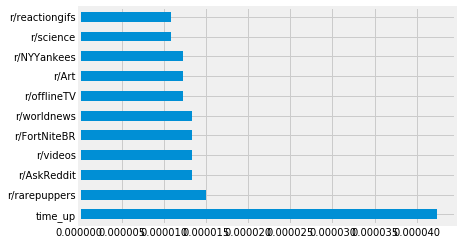

In [533]:
pd.Series(dict(zip(indep_train6.columns,model.coef_[0]))).abs().sort_values(ascending=False).head(11).plot(kind='barh')

Gridsearch, best C

In [536]:
# Declare indep
indep_train20 = indep_train6[['time_up','r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR', 'r/worldnews','r/offlineTV','r/Art','r/NYYankees','r/science','r/reactiongifs']]
indep_test20 = indep_test6[['time_up','r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR', 'r/worldnews','r/offlineTV','r/Art','r/NYYankees','r/science','r/reactiongifs']]

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train20, dep_train)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search fail

{'best_params': {'C': 10.0, 'solver': 'newton-cg'},
 'best_score': 0.7540433904959443}

I can't get it to converge (changing max_iter)

Model + best C

In [537]:
# chose model and use best C
model = LogisticRegression(C=10.0)

# call function
evaluate_model(model, indep_train20, indep_test20, dep_train, dep_test)

{'accuracy': 0.6491228070175439,
 'pred_mean': 0.7017543859649122,
 'score_mean': 0.5703886693017127,
 'y_pred_mean': 0.5263157894736842}

######

**time_up + top 10 subreddit dummies**

Gridsearch, best C

In [538]:
# Declare indep
indep_train10 = indep_train[['time_up','r/pics', 'r/aww','r/funny','r/FortNiteBR','r/BlackPeopleTwitter','r/todayilearned', 'r/rupaulsdragrace', 'r/marvelstudios', 'r/food', 'r/rarepuppers']]
indep_test10 = indep_test[['time_up','r/pics', 'r/aww','r/funny','r/FortNiteBR','r/BlackPeopleTwitter','r/todayilearned', 'r/rupaulsdragrace', 'r/marvelstudios', 'r/food', 'r/rarepuppers']]

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train10, dep_train)

{'best_params': {'C': 1e-09, 'solver': 'newton-cg'},
 'best_score': 0.6716898774028668}

Model + best C

In [539]:
# chose model and use best C
model = LogisticRegression(C=1e-09)

# call function
evaluate_model(model, indep_train10, indep_test10, dep_train, dep_test)

{'accuracy': 0.6403508771929824,
 'pred_mean': 0.8333333333333334,
 'score_mean': 0.6055994729907773,
 'y_pred_mean': 0.5175438596491229}

###############

**time_up + 10 most important words and 10 most important subreddits from feature importance test**

Gridsearch, best C

In [540]:
# Declare indep and dep
indep_train22 = indep_train[['time_up','legit', 'flip', 'watching', 'rollin', 'absolutelynotme_irl', 'downhill' ,'happiness', 'interesting', 'fucking', 'eye',
                             'r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR', 'r/worldnews','r/offlineTV','r/Art','r/NYYankees','r/science','r/reactiongifs']]
indep_test22 = indep_test[['time_up','legit', 'flip', 'watching', 'rollin', 'absolutelynotme_irl', 'downhill' ,'happiness', 'interesting', 'fucking', 'eye',
                             'r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR', 'r/worldnews','r/offlineTV','r/Art','r/NYYankees','r/science','r/reactiongifs']]
dep_train22 = dep_train
dep_test22 = dep_test

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train22, dep_train22)

{'best_params': {'C': 100.0, 'solver': 'newton-cg'},
 'best_score': 0.7655713174562021}

Model + best C

In [541]:
# chose model and use best C
model = LogisticRegression(C=100.0)

# call function
evaluate_model(model, indep_train22, indep_test22, dep_train22, dep_test22)

{'accuracy': 0.6491228070175439,
 'pred_mean': 0.7017543859649122,
 'score_mean': 0.5703886693017127,
 'y_pred_mean': 0.5263157894736842}

**time_up + 5 most important words and 5 most important subreddits from feature importance test**

In [545]:
# Declare indep and dep
indep_train26 = indep_train[['time_up','absolutelynotme_irl', 'downhill' ,'happiness', 'interesting', 'fucking',
                             'r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR', 'r/worldnews']]
indep_test26 = indep_test[['time_up','absolutelynotme_irl', 'downhill' ,'happiness', 'interesting', 'fucking',
                             'r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR', 'r/worldnews']]
dep_train26 = dep_train
dep_test26 = dep_test

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train26, dep_train26)

/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')
/anaconda3/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/optimize.py:195: UserWarning: Line Search failed
  warnings.warn('Line Search failed')


{'best_params': {'C': 1.0, 'solver': 'newton-cg'},
 'best_score': 0.7511750435201304}

I can't get it to converge (changing max_iter)

Model + best C

In [546]:
# chose model and use best C
model = LogisticRegression(C=10.0)

# call function
evaluate_model(model, indep_train26, indep_test26, dep_train26, dep_test26)

{'accuracy': 0.6491228070175439,
 'pred_mean': 0.7368421052631579,
 'score_mean': 0.5616930171277997,
 'y_pred_mean': 0.5263157894736842}

**time_up + 4 most important words and 4 most important subreddits from feature importance test**

In [547]:
# Declare indep and dep
indep_train30 = indep_train[['time_up','downhill' ,'happiness', 'interesting', 'fucking',
                             'r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR']]
indep_test30 = indep_test[['time_up','downhill' ,'happiness', 'interesting', 'fucking',
                             'r/rarepuppers', 'r/AskReddit','r/videos','r/FortNiteBR']]
dep_train30 = dep_train
dep_test30 = dep_test

# Gridsearch
grid = {'C': np.power(10.0, np.arange(-10, 10)), 'solver': ['newton-cg']} # newton with ovr
clf = LogisticRegression(penalty='l2', random_state=24, max_iter=10000) #ovr default, l2 with newton

get_best_hype(clf, grid, indep_train30, dep_train30)

{'best_params': {'C': 1.0, 'solver': 'newton-cg'},
 'best_score': 0.741121245231305}

Model + best C

In [548]:
# chose model and use best C
model = LogisticRegression(C=1.0)

# call function
evaluate_model(model, indep_train30, indep_test30, dep_train30, dep_test30)

{'accuracy': 0.6403508771929824,
 'pred_mean': 0.7368421052631579,
 'score_mean': 0.570026350461133,
 'y_pred_mean': 0.5175438596491229}

### BESTA LogReg MODEL

**time_up + all subreddit dummies**

In [550]:
# chose model and use best C
model = LogisticRegression(C=1e-06)

# call function
evaluate_model(model, indep_train6, indep_test6, dep_train, dep_test)

{'accuracy': 0.6578947368421053,
 'pred_mean': 0.8157894736842105,
 'score_mean': 0.5794795783926218,
 'y_pred_mean': 0.5350877192982456}

#### Is model OVERFITTED?

In [554]:
# make a loop and look att different numbers of C 
scores_test = []
scores_train = []
c_list = []

for i in range(0,20):
    c = (i+0.001)/50
    clf = LogisticRegression(C = c, random_state = 42)
    clf.fit(indep_train6, dep_train)
    clf.score(indep_test6, dep_test)

    c_list.append(c)
    scores_train.append(clf.score(indep_train6, dep_train))
    scores_test.append(clf.score(indep_test6, dep_test))

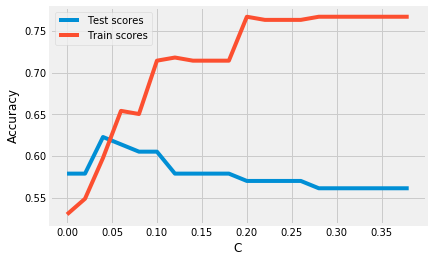

In [555]:
# visualize the data in learning curves 
plt.plot(c_list, scores_test, label='Test scores')
plt.plot(c_list, scores_train, label='Train scores')
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend()

#### Best model new C (look at the plot)

In [561]:
# chose model and use best C
model = LogisticRegression(C=0.4)

# call function
evaluate_model(model, indep_train6, indep_test6, dep_train, dep_test)

{'accuracy': 0.6578947368421053,
 'pred_mean': 0.6842105263157895,
 'score_mean': 0.5181488801054018,
 'y_pred_mean': 0.41228070175438597}

### Random forest

I used the same functions for the LogReg and the Random forest. But you do not really have to scale inte the Random forest. But it's already in the function, so I just wanted to make a comment about that it will not make any difference for the Random forest. 

**time_up**

Gridsearch, best max_depth

In [562]:
# Declare indep and dep
indep_train1 = indep_train[['time_up']]
indep_test1 = indep_test[['time_up']]
dep_train1 = dep_train
dep_test1 = dep_test

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train1, dep_train1)

{'best_params': {'max_depth': 3}, 'best_score': 0.6967844179414053}

Model + best max_depth

In [563]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=24) # default n_estimators = 10

# call function
evaluate_model(model, indep_train1, indep_test1, dep_train1, dep_test1)

{'accuracy': 0.5701754385964912,
 'pred_mean': 0.6842105263157895,
 'score_mean': 0.5881752305665349,
 'y_pred_mean': 0.6578947368421053}

#############

**time_up + all words from NLP + all subreddit**

Gridsearch, best max_depth

In [564]:
# Declare indep
# don't forget to drop a word and a subreddit
indep_train2 = indep_train.drop(['comments', 'delta_com', 'class_com', 'title', 'subreddit', 'got', 'r/gifs'], axis=1)
indep_test2 = indep_test.drop(['comments', 'delta_com', 'class_com', 'title', 'subreddit', 'got', 'r/gifs'], axis=1)

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train2, dep_train)

{'best_params': {'max_depth': 1}, 'best_score': 0.6509552205637246}

Model + best max_depth

In [565]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=1, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train2, indep_test2, dep_train, dep_test)

{'accuracy': 0.5789473684210527,
 'pred_mean': 1.0,
 'score_mean': 0.5791172595520421,
 'y_pred_mean': 1.0}

###############################################################################

**time_up + all words from NLP**

Gridsearch, best max_depth

In [566]:
# Declare indep
# don't forget to drop a word
indep_train4 = indep_trainW.drop(['comments', 'delta_com', 'class_com', 'title', 'subreddit','got'], axis=1)
indep_test4 = indep_testW.drop(['comments', 'delta_com', 'class_com', 'title', 'subreddit','got'], axis=1)

# Vridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train4, dep_train)

{'best_params': {'max_depth': 1}, 'best_score': 0.6454278862180082}

Model + best max_depth

In [567]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=1, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train4, indep_test4, dep_train, dep_test)

{'accuracy': 0.5789473684210527,
 'pred_mean': 1.0,
 'score_mean': 0.5791172595520421,
 'y_pred_mean': 1.0}

################

**What are the 10 most important features and what words does the features correspond to?**<BR />
With the code part for the feature importance and the word I got help from Adam with the code.

In [569]:
# Look at the feature importance
pd.Series(dict(zip(indep_train4.columns,model.feature_importances_))).abs().sort_values(ascending=False).head(10)

sad         0.02
way         0.02
better      0.02
fresh       0.02
brain       0.02
human       0.02
gunpoint    0.01
hero        0.01
correct     0.01
paint       0.01
dtype: float64

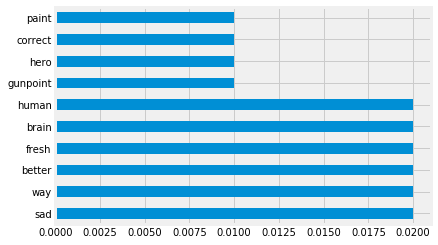

In [570]:
# Look at the feature importance in a plot
pd.Series(dict(zip(indep_train4.columns,model.feature_importances_))).abs().sort_values(ascending=False).head(10).plot(kind='barh')

#########

**time_up + 10 most important words from feature importance test**

Gridsearch, best max_depth

In [573]:
# Declare indep
indep_train12 = indep_train[['time_up','sad', 'way','better','fresh', 'brain','human','gunpoint', 'hero','correct','paint']]
indep_test12 = indep_test[['time_up','sad', 'way','better','fresh', 'brain','human','gunpoint', 'hero','correct','paint']]

# Vridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train12, dep_train)

{'best_params': {'max_depth': 7}, 'best_score': 0.7043158079928886}

Model + best max_depth

In [574]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train12, indep_test12, dep_train, dep_test)

{'accuracy': 0.5789473684210527,
 'pred_mean': 0.7368421052631579,
 'score_mean': 0.61465744400527,
 'y_pred_mean': 0.6491228070175439}

**time_up + top 10 words from NLP**

Gridsearch, best max_depth

In [576]:
# Declare indep
indep_train8 = indep_train[['time_up', 'year', 'people','just','work','time','til', 'oc', 'don', 'black', 'trump']]
indep_test8 = indep_test[['time_up', 'year', 'people','just','work','time','til', 'oc', 'don', 'black', 'trump']]

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(random_state=24)

get_best_hype(rfc, grid, indep_train8, dep_train)

{'best_params': {'max_depth': 9}, 'best_score': 0.6647300825956518}

Model + best max_depth

In [577]:
# chose model and use best max_depth and balance the classes
model = RandomForestClassifier(max_depth=9, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train8, indep_test8, dep_train, dep_test)

{'accuracy': 0.5614035087719298,
 'pred_mean': 0.7280701754385965,
 'score_mean': 0.6229578392621871,
 'y_pred_mean': 0.6140350877192983}

#################################################################################################

**time_up + all subreddit dummies**

Gridsearch, best max_depth

In [579]:
# Declare indep
# don't forget to drop a subreddit
indep_train6 = indep_trainS.drop(['comments', 'title', 'subreddit','r/gifs'], axis=1)
indep_test6 = indep_testS.drop(['comments', 'title', 'subreddit', 'r/gifs'], axis=1)

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train6, dep_train)

{'best_params': {'max_depth': 9}, 'best_score': 0.7035382791955258}

Model + best max_depth

In [580]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=9, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train6, indep_test6, dep_train, dep_test)

{'accuracy': 0.5877192982456141,
 'pred_mean': 0.9385964912280702,
 'score_mean': 0.6150527009222662,
 'y_pred_mean': 0.6754385964912281}

**What are the 10 most important features and what subreddits the features correspond to?**<BR />

In [581]:
# Look at the feature importance
pd.Series(dict(zip(indep_train6.columns,model.feature_importances_))).abs().sort_values(ascending=False).head(11)

time_up                 0.216194
r/rarepuppers           0.024371
r/offlineTV             0.021549
r/FortNiteBR            0.020731
r/Art                   0.018438
r/videos                0.015929
r/worldnews             0.015703
r/AskReddit             0.014513
r/NYYankees             0.013638
r/dragonballfighterz    0.012301
r/baseball              0.011807
dtype: float64

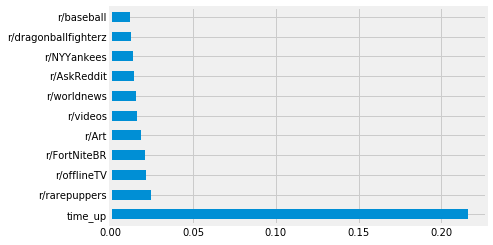

In [582]:
# Look at the feature importance in a plot
pd.Series(dict(zip(indep_train6.columns,model.feature_importances_))).abs().sort_values(ascending=False).head(11).plot(kind='barh')

In [295]:
#########

**time_up + 10 most important subreddits from feature importance test**

Gridsearch, best max_depth

In [587]:
# Declare indep
indep_train12 = indep_train[['time_up','r/rarepuppers', 'r/offlineTV','r/FortNiteBR','r/Art', 'r/videos','r/worldnews','r/AskReddit', 'r/NYYankees','r/dragonballfighterz','r/baseball']]
indep_test12 = indep_test[['time_up','r/rarepuppers', 'r/offlineTV','r/FortNiteBR','r/Art', 'r/videos','r/worldnews','r/AskReddit', 'r/NYYankees','r/dragonballfighterz','r/baseball']]

# Vridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train12, dep_train)

{'best_params': {'max_depth': 8}, 'best_score': 0.7355660394829437}

Model + best max_depth

In [588]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train12, indep_test12, dep_train, dep_test)

{'accuracy': 0.5877192982456141,
 'pred_mean': 0.6842105263157895,
 'score_mean': 0.6407444005270092,
 'y_pred_mean': 0.6754385964912281}

#################

** time_up + top 10 subreddit dummies**

Gridsearch, best max_depth

In [589]:
# Declare indep
indep_train10 = indep_train[['time_up', 'r/pics', 'r/aww','r/funny','r/FortNiteBR','r/BlackPeopleTwitter','r/todayilearned', 'r/rupaulsdragrace', 'r/marvelstudios', 'r/food', 'r/rarepuppers']]
indep_test10 = indep_test[['time_up', 'r/pics', 'r/aww','r/funny','r/FortNiteBR','r/BlackPeopleTwitter','r/todayilearned', 'r/rupaulsdragrace', 'r/marvelstudios', 'r/food', 'r/rarepuppers']]

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train10, dep_train)

{'best_params': {'max_depth': 3}, 'best_score': 0.6900885217971037}

Model + best max_depth

In [591]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train10, indep_test10, dep_train, dep_test)

{'accuracy': 0.5701754385964912,
 'pred_mean': 0.7368421052631579,
 'score_mean': 0.6324440052700921,
 'y_pred_mean': 0.6578947368421053}

##################################################################################

**time_up + 10 most important words and 10 most important subreddits from feature importance test**

Gridsearch, best max_depth

In [593]:
# Declare indep and dep
indep_train16 = indep_train[['time_up','sad', 'way','better','fresh', 'brain','human','gunpoint', 'hero','correct','paint',
                             'r/rarepuppers', 'r/offlineTV','r/FortNiteBR','r/Art', 'r/videos','r/worldnews','r/AskReddit', 'r/NYYankees','r/dragonballfighterz','r/baseball']]
indep_test16 = indep_test[['time_up','sad', 'way','better','fresh', 'brain','human','gunpoint', 'hero','correct','paint',
                             'r/rarepuppers', 'r/offlineTV','r/FortNiteBR','r/Art', 'r/videos','r/worldnews','r/AskReddit', 'r/NYYankees','r/dragonballfighterz','r/baseball']]
dep_train16 = dep_train
dep_test16 = dep_test

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train16, dep_train16)

{'best_params': {'max_depth': 7}, 'best_score': 0.7349944442386755}

Model + best max_depth

In [594]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train16, indep_test16, dep_train16, dep_test16)

{'accuracy': 0.5964912280701754,
 'pred_mean': 0.6842105263157895,
 'score_mean': 0.6407444005270092,
 'y_pred_mean': 0.6666666666666666}

**time_up + 5 most important words and 5 most important subreddits from feature importance test**

In [595]:
# Declare indep and dep
indep_train24 = indep_train[['time_up','sad', 'way','better','fresh', 'brain',
                             'r/rarepuppers', 'r/offlineTV','r/FortNiteBR','r/Art', 'r/videos']]
indep_test24 = indep_test[['time_up','sad', 'way','better','fresh', 'brain',
                             'r/rarepuppers', 'r/offlineTV','r/FortNiteBR','r/Art', 'r/videos']]
dep_train24 = dep_train
dep_test24 = dep_test

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train24, dep_train24)

{'best_params': {'max_depth': 8}, 'best_score': 0.7220572058224377}

Model + best max_depth

In [596]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=8, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train24, indep_test24, dep_train24, dep_test24)

{'accuracy': 0.5789473684210527,
 'pred_mean': 0.6842105263157895,
 'score_mean': 0.61465744400527,
 'y_pred_mean': 0.6491228070175439}

#### Try with just one each

In [597]:
# Declare indep and dep
indep_train28 = indep_train[['time_up','life','r/goddesses']]
indep_test28 = indep_test[['time_up','life','r/goddesses']]
dep_train28 = dep_train
dep_test28 = dep_test

# Gridsearch
grid = {'max_depth': np.arange(1,10)}
rfc = RandomForestClassifier(n_estimators=100, random_state=24)

get_best_hype(rfc, grid, indep_train28, dep_train28)

{'best_params': {'max_depth': 4}, 'best_score': 0.6912431941923775}

In [598]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train28, indep_test28, dep_train28, dep_test28)

{'accuracy': 0.5701754385964912,
 'pred_mean': 0.6842105263157895,
 'score_mean': 0.5964756258234518,
 'y_pred_mean': 0.6578947368421053}

### BEST RF Model

**time_up + 10 most important words and 10 most important subreddits **

Model + best max_depth

In [599]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=7, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train16, indep_test16, dep_train16, dep_test16)

{'accuracy': 0.5964912280701754,
 'pred_mean': 0.6842105263157895,
 'score_mean': 0.6407444005270092,
 'y_pred_mean': 0.6666666666666666}

### Is model OVERFITTED?

In [600]:
# make a loop and look att different numbers of C 
scores_test = []
scores_train = []
c_list = []

for i in range(0,20):
    c = (i+0.001)/10
    clf = LogisticRegression(C = c, random_state = 42)
    clf.fit(indep_train16, dep_train16)
    clf.score(indep_test16, dep_test16)

    c_list.append(c)
    scores_train.append(clf.score(indep_train16, dep_train16))
    scores_test.append(clf.score(indep_test16, dep_test16))

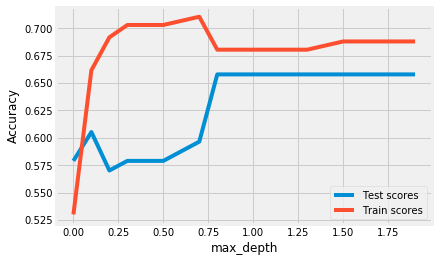

In [601]:
# visualize the data in learning curves 
plt.plot(c_list, scores_test, label='Test scores')
plt.plot(c_list, scores_train, label='Train scores')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()

### Best model new max_depth (look at the plot)

In [ ]:
# chose model and use best max_depth
model = RandomForestClassifier(max_depth=1, n_estimators=100, random_state=24)

# call function
evaluate_model(model, indep_train16, indep_test16, dep_train16, dep_test16)

In [ ]:
# the accuracy is not improving if max_depth is changed

# Conclusion
---
LogReg time_up + all subreddit dummies gave the best accuracy score. And in the end if you look at how the model is overfitting and change the hyperparameter C. The model is not that overfitted. 
The model give you an accuracy score of 0.6578947368421053.